# Load and Save Full Volumes

In [3]:
import os
import numpy as np
import pydicom

# ----- Default Metadata -----
DEFAULT_METADATA = {
    "slice_thickness": 2.5,       # mm (not used in this snippet but can be stored if needed)
    "slice_spacing": 2.5,         # mm (not used directly in HU conversion)
    "pixel_spacing": (0.7, 0.7),  # (not used directly in HU conversion)
    "origin": (0.0, 0.0, 0.0),
    "orientation": (1.0, 0.0, 0.0, 0.0, 1.0, 0.0),
    "rescale_intercept": -1024.0,  # Standard air HU value
    "rescale_slope": 1.0,         # Default scaling factor
    "contrast_used": False
}

# ----- Functions for CT Scan Processing -----
def load_scan(dicom_dir):
    """
    Load and sort all DICOM files in a directory by their z-axis location.
    
    Parameters:
        dicom_dir (str): Path to the directory containing DICOM files.
        
    Returns:
        List of sorted pydicom FileDataset objects.
    """
    slices = [
        pydicom.dcmread(os.path.join(dicom_dir, f))
        for f in os.listdir(dicom_dir) if f.endswith(".dcm")
    ]
    # Only consider slices that have the ImagePositionPatient attribute
    slices = [s for s in slices if hasattr(s, "ImagePositionPatient")]
    slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))
    return slices

def convert_to_hu(slices, rescale_intercept, rescale_slope):
    """
    Convert raw DICOM pixel data to Hounsfield Units (HU).
    
    Parameters:
        slices (list): Sorted DICOM slices.
        rescale_intercept (float): The intercept to add.
        rescale_slope (float): The slope for scaling.
    
    Returns:
        A 3D numpy array of the CT volume in HU.
    """
    # Stack the pixel arrays to form a 3D volume
    image = np.stack([s.pixel_array for s in slices], axis=0).astype(np.int16)
    
    if rescale_slope != 1:
        image = rescale_slope * image.astype(np.float32)
        image = image.astype(np.int16)
    image += np.int16(rescale_intercept)
    
    return image

def save_volume(output_dir, hu_volume, patient_id):
    """
    Save the processed CT scan volume as a NumPy file.
    
    Parameters:
        output_dir (str): The directory where the output will be saved.
        hu_volume (numpy.ndarray): The 3D CT volume in HU.
        patient_id (str): The patient identifier, used for naming the file.
    """
    os.makedirs(output_dir, exist_ok=True)
    npy_filename = f"{patient_id}_full_volume.npy"
    npy_path = os.path.join(output_dir, npy_filename)
    np.save(npy_path, hu_volume)
    print(f"Saved CT scan (HU) for Patient {patient_id} at: {npy_path}")

def process_patient_scan(patient_folder, patient_id, output_folder):
    """
    Process a single patient scan by loading the DICOM series, converting to HU,
    and saving the resulting volume.
    
    Parameters:
        patient_folder (str): Path to the folder containing DICOM files.
        patient_id (str): The patient identifier.
        output_folder (str): The folder where processed data will be saved.
    """
    print(f"Processing patient {patient_id}...")
    slices = load_scan(patient_folder)
    if not slices:
        print(f"No valid DICOM files found in {patient_folder}. Skipping.")
        return
    hu_volume = convert_to_hu(
        slices,
        DEFAULT_METADATA["rescale_intercept"],
        DEFAULT_METADATA["rescale_slope"]
    )
    save_volume(output_folder, hu_volume, patient_id)

def main():
    # ----- Define Paths and Classes -----
    # Input root folder containing 'RealCancerous' and 'FakeAddedCancer'
    input_root = "../data"
    # Output root folder for processed data (mirrors the original structure)
    output_root = "../data_processed"
    classes = ["RealCancerous", "FakeAddedCancer"]

    # Iterate over each class folder
    for cls in classes:
        input_class_dir = os.path.join(input_root, cls)
        output_class_dir = os.path.join(output_root, cls)
        
        # List all entries in the class directory
        for entry in os.listdir(input_class_dir):
            entry_path = os.path.join(input_class_dir, entry)
            # Process only directories (skip CSV metadata files)
            if os.path.isdir(entry_path):
                patient_id = entry  # e.g., "1280" or "1456"
                output_patient_dir = os.path.join(output_class_dir, patient_id)
                process_patient_scan(entry_path, patient_id, output_patient_dir)

if __name__ == "__main__":
    main()


Processing patient 2244...
Saved CT scan (HU) for Patient 2244 at: ../data_processed/RealCancerous/2244/2244_full_volume.npy
Processing patient 2220...
Saved CT scan (HU) for Patient 2220 at: ../data_processed/RealCancerous/2220/2220_full_volume.npy
Processing patient 1546...
Saved CT scan (HU) for Patient 1546 at: ../data_processed/RealCancerous/1546/1546_full_volume.npy
Processing patient 3025...
Saved CT scan (HU) for Patient 3025 at: ../data_processed/RealCancerous/3025/3025_full_volume.npy
Processing patient 2575...
Saved CT scan (HU) for Patient 2575 at: ../data_processed/RealCancerous/2575/2575_full_volume.npy
Processing patient 3099...
Saved CT scan (HU) for Patient 3099 at: ../data_processed/RealCancerous/3099/3099_full_volume.npy
Processing patient 6031...
Saved CT scan (HU) for Patient 6031 at: ../data_processed/RealCancerous/6031/6031_full_volume.npy
Processing patient 1871...
Saved CT scan (HU) for Patient 1871 at: ../data_processed/RealCancerous/1871/1871_full_volume.npy


## Display a few Data cubes to see what we are dealing with


Processing class: RealCancerous
Displaying cube from class: RealCancerous, Patient: 1546, Row: 0


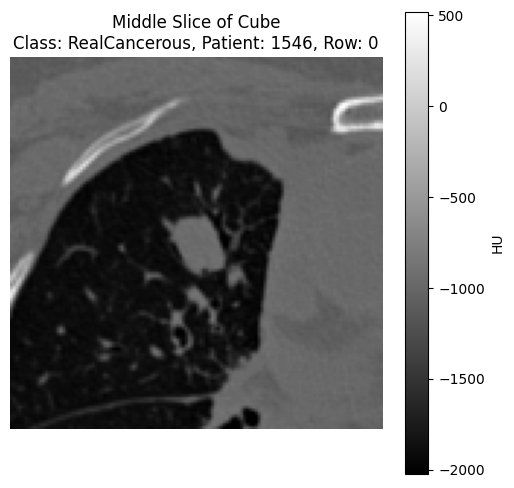

Displaying cube from class: RealCancerous, Patient: 1045, Row: 1


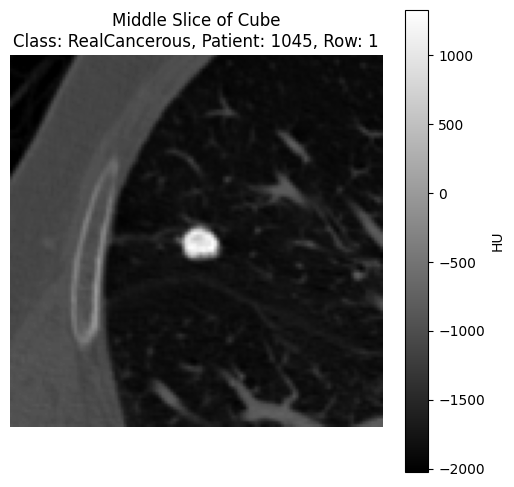

Displaying cube from class: RealCancerous, Patient: 2244, Row: 2


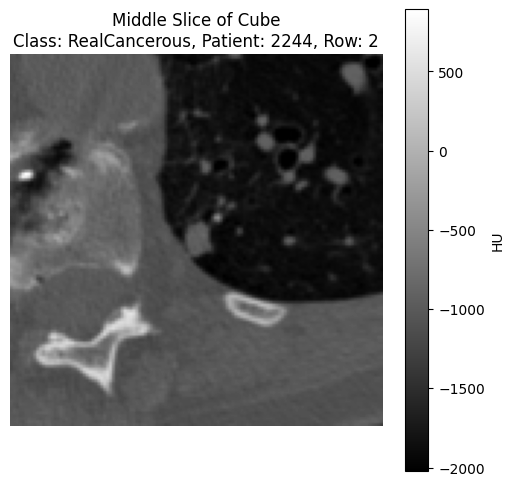

Displaying cube from class: RealCancerous, Patient: 2244, Row: 3


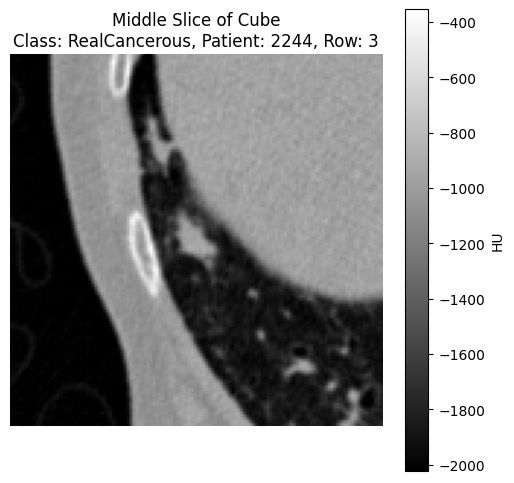

Displaying cube from class: RealCancerous, Patient: 2244, Row: 4


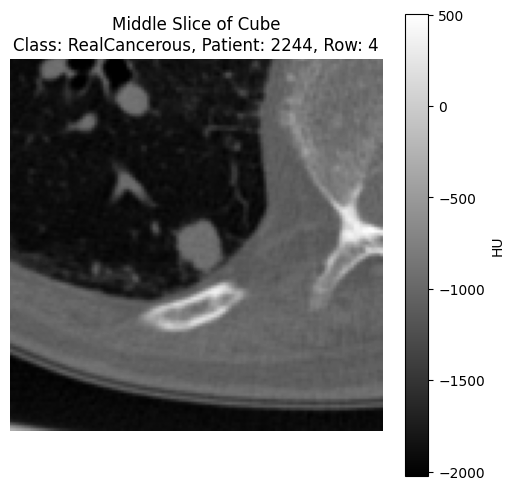


Processing class: FakeAddedCancer
Displaying cube from class: FakeAddedCancer, Patient: 4142, Row: 0


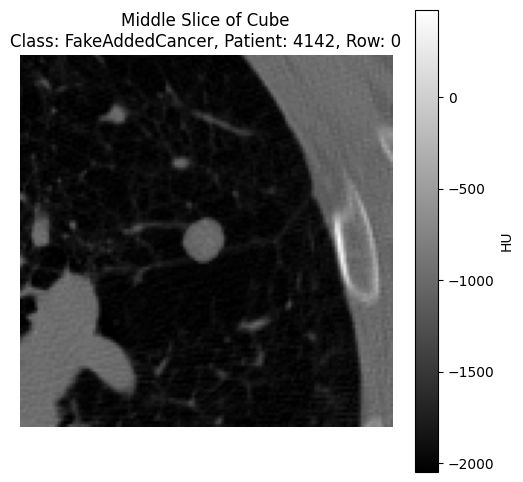

Displaying cube from class: FakeAddedCancer, Patient: 2838, Row: 1


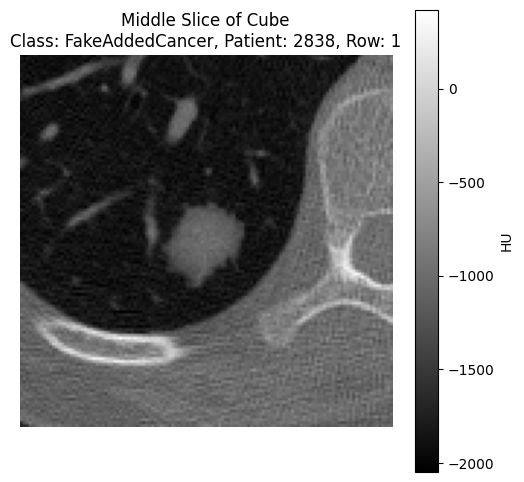

Displaying cube from class: FakeAddedCancer, Patient: 2320, Row: 2


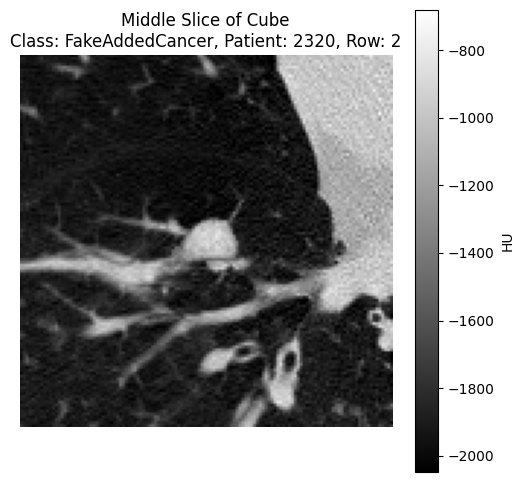

Displaying cube from class: FakeAddedCancer, Patient: 5614, Row: 3


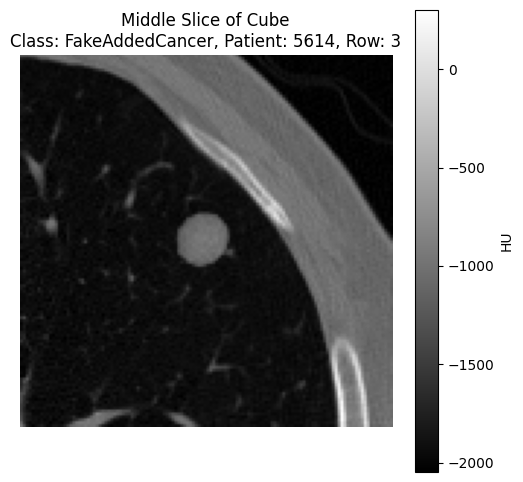

Displaying cube from class: FakeAddedCancer, Patient: 1452, Row: 4


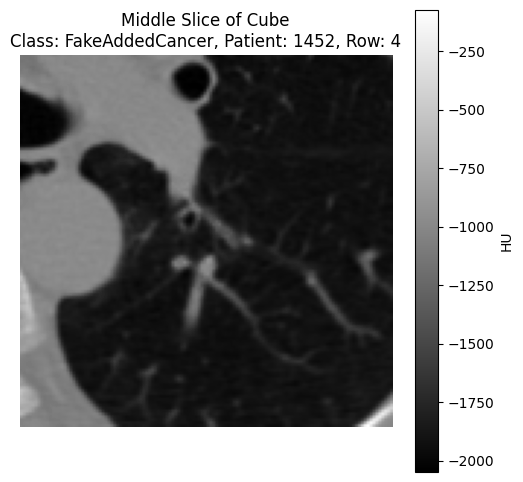

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Utility functions ----
def extract_cube(ct_scan, center, cube_size=(128, 128, 128)):
    """
    Extracts a cube of given size from a 3D CT scan centered at a specified location.

    Parameters:
        ct_scan (numpy array): The 3D CT scan in HU.
        center (tuple): (z, y, x) coordinates of the cube center.
        cube_size (tuple): (depth, height, width) of the cube.

    Returns:
        numpy array: Extracted cube.
    """
    z, y, x = center
    d, h, w = cube_size

    # Compute boundaries
    z_min, z_max = max(0, z - d // 2), min(ct_scan.shape[0], z + d // 2)
    y_min, y_max = max(0, y - h // 2), min(ct_scan.shape[1], y + h // 2)
    x_min, x_max = max(0, x - w // 2), min(ct_scan.shape[2], x + w // 2)

    # Extract the cube
    cube = ct_scan[z_min:z_max, y_min:y_max, x_min:x_max]

    # Ensure cube size consistency by padding if necessary
    pad_z = (d - cube.shape[0]) // 2
    pad_y = (h - cube.shape[1]) // 2
    pad_x = (w - cube.shape[2]) // 2

    cube = np.pad(
        cube,
        ((pad_z, d - cube.shape[0] - pad_z),
         (pad_y, h - cube.shape[1] - pad_y),
         (pad_x, w - cube.shape[2] - pad_x)),
        mode='constant', constant_values=-1000  # pad with air HU value
    )

    return cube

def display_middle_slice(cube, cls, patient_id, idx):
    """
    Displays the middle slice of the extracted cube and prints which class it belongs to.

    Parameters:
        cube (numpy array): Extracted 3D cube.
        cls (str): The class of the CT scan (e.g., "RealCancerous" or "FakeAddedCancer").
        patient_id (str): The patient ID.
        idx (int): Index of the row in the CSV file.
    """
    print(f"Displaying cube from class: {cls}, Patient: {patient_id}, Row: {idx}")

    middle_slice = cube[cube.shape[0] // 2]  # middle slice along Z-axis

    plt.figure(figsize=(6, 6))
    plt.imshow(middle_slice, cmap='gray')
    plt.colorbar(label="HU")
    plt.title(f"Middle Slice of Cube\nClass: {cls}, Patient: {patient_id}, Row: {idx}")
    plt.axis("off")
    plt.show()

def main():
    # Change these paths if your directory structure differs
    data_processed_root = "../data_processed"
    
    # The two classes in your dataset
    classes = ["RealCancerous", "FakeAddedCancer"]
    
    # Number of cubes to extract and display per class
    num_cubes_per_class = 5
    
    for cls in classes:
        print(f"\nProcessing class: {cls}")
        
        # e.g., "data_processed/RealCancerous/RealCancerous.csv"
        class_csv_path = os.path.join(data_processed_root, cls, f"{cls}.csv")
        if not os.path.isfile(class_csv_path):
            print(f"CSV file not found for class {cls}: {class_csv_path}")
            continue
        
        # Read CSV containing (uuid, slice, x, y)
        df = pd.read_csv(class_csv_path)
        
        # Take the first N rows (you can randomize or change the logic as needed)
        df_sample = df.head(num_cubes_per_class)
        
        for idx, row in df_sample.iterrows():
            patient_id = str(row["uuid"])  # Patient folder name
            # The CSV columns are named: 'slice', 'x', 'y'
            # center = (z, y, x)
            z_center = int(row["slice"])
            x_center = int(row["x"])
            y_center = int(row["y"])
            center = (z_center, y_center, x_center)
            
            # Path to the patient's CT volume .npy file, e.g. "1280_full_volume.npy"
            npy_file_name = f"{patient_id}_full_volume.npy"
            npy_path = os.path.join(data_processed_root, cls, patient_id, npy_file_name)
            
            if not os.path.isfile(npy_path):
                print(f"CT volume file not found: {npy_path}")
                continue
            
            # Load the patient’s 3D CT scan
            ct_scan = np.load(npy_path)
            
            # Extract a cube around the center
            cube = extract_cube(ct_scan, center, cube_size=(128, 128, 128))
            
            # Display the middle slice
            display_middle_slice(cube, cls, patient_id, idx)

if __name__ == "__main__":
    main()


# Using Cell Magic Wand Tool to Mask ROI

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, binary_fill_holes

# ============================
# Magic Wand Tool Functions
# ============================

def coord_polar_to_cart(r, theta, center):
    '''Converts polar coordinates around center to Cartesian'''
    x = r * np.cos(theta) + center[0]
    y = r * np.sin(theta) + center[1]
    return x, y

def coord_cart_to_polar(x, y, center):
    '''Converts Cartesian coordinates to polar'''
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    theta = np.arctan2((y - center[1]), (x - center[0]))
    return r, theta

def image_cart_to_polar(image, center, min_radius, max_radius, phase_width, zoom_factor=1):
    '''Converts an image from cartesian to polar coordinates around center'''

    if zoom_factor != 1:
        image = zoom(image, (zoom_factor, zoom_factor), order=4)
        center = (center[0]*zoom_factor + zoom_factor/2, center[1]*zoom_factor + zoom_factor/2)
        min_radius = min_radius * zoom_factor
        max_radius = max_radius * zoom_factor
    
    # Pad if necessary
    max_x, max_y = image.shape
    pad_dist_x = np.max([(center[0] + max_radius) - max_x, -(center[0] - max_radius)])
    pad_dist_y = np.max([(center[1] + max_radius) - max_y, -(center[1] - max_radius)])
    pad_dist = int(np.max([0, pad_dist_x, pad_dist_y]))
    if pad_dist != 0:
        image = np.pad(image, pad_dist, mode='constant')

    # Create polar coordinate grid
    theta, r = np.meshgrid(np.linspace(0, 2*np.pi, phase_width),
                           np.arange(min_radius, max_radius))
    x, y = coord_polar_to_cart(r, theta, center)
    x, y = np.round(x).astype(int), np.round(y).astype(int)

    polar = image[x, y]
    polar.reshape((max_radius - min_radius, phase_width))
    return polar

def mask_polar_to_cart(mask, center, min_radius, max_radius, output_shape, zoom_factor=1):
    '''Converts a polar binary mask back to Cartesian and places it in an image of zeros.'''
    if zoom_factor != 1:
        center = (center[0]*zoom_factor + zoom_factor/2, center[1]*zoom_factor + zoom_factor/2)
        min_radius = min_radius * zoom_factor
        max_radius = max_radius * zoom_factor
        output_shape = tuple([int(a * zoom_factor) for a in output_shape])
    
    image = np.zeros(output_shape, dtype=float)

    theta, r = np.meshgrid(np.linspace(0, 2*np.pi, mask.shape[1]),
                           np.arange(0, max_radius))
    x, y = coord_polar_to_cart(r, theta, center)
    x, y = np.round(x).astype(int), np.round(y).astype(int)
    x = np.clip(x, 0, image.shape[0]-1)
    y = np.clip(y, 0, image.shape[1]-1)

    image[x, y] = mask

    if zoom_factor != 1:
        zf = 1/float(zoom_factor)
        image = zoom(image, (zf, zf), order=4)

    image = (image > 0.5).astype(int)  # Force binary
    image = binary_fill_holes(image)
    return image

def find_edge_2d(polar, min_radius):
    '''Dynamic programming algorithm to find edge given polar image'''
    if polar.ndim != 2:
        raise ValueError("argument to find_edge_2d must be 2D")
    
    # Shifted versions for dynamic programming
    values_right_shift      = np.pad(polar, ((0, 0), (0, 1)), mode='constant')[:, 1:]
    values_closeright_shift = np.pad(polar, ((1, 0), (0, 1)), mode='constant')[:-1, 1:]
    values_awayright_shift  = np.pad(polar, ((0, 1), (0, 1)), mode='constant')[1:, 1:]

    # Combine possible moves: away-right, right, closeright
    values_move = np.zeros((polar.shape[0], polar.shape[1], 3))
    values_move[:, :, 0] = polar + values_awayright_shift
    values_move[:, :, 1] = polar + values_right_shift
    values_move[:, :, 2] = polar + values_closeright_shift

    values = values_move.max(axis=2)
    directions = np.argmax(values_move, axis=2)
    directions = directions - 1
    directions = -directions

    # Edge following
    edge = []
    mask = np.zeros(polar.shape, dtype=int)
    
    r_max = 0
    r = 0
    for i, v in enumerate(values[:, 0]):
        if v >= r_max:
            r, r_max = i, v
    edge.append((r + min_radius, 0))
    mask[0:r+1, 0] = 1

    for t in range(1, polar.shape[1]):
        r += directions[r, t-1]
        r = max(0, min(r, directions.shape[0]-1))
        edge.append((r + min_radius, t))
        mask[0:r+1, t] = 1

    # Add inside for min_radius offset
    new_mask = np.ones((min_radius + mask.shape[0], mask.shape[1]), dtype=int)
    new_mask[min_radius:, :] = mask
    return np.array(edge), new_mask

def edge_polar_to_cart(edge, center):
    '''Converts a list of polar edge points to a list of cartesian edge points'''
    cart_edge = []
    for (r, t) in edge:
        x, y = coord_polar_to_cart(r, t, center)
        cart_edge.append((round(x), round(y)))
    return cart_edge

def cell_magic_wand_single_point(image, center, min_radius, max_radius,
                                 roughness=2, zoom_factor=1):
    '''Wand tool for a single center point.'''
    if roughness < 1:
        roughness = 1
    if min_radius < 0:
        min_radius = 0
    if max_radius <= min_radius:
        max_radius = min_radius + 1
    if zoom_factor <= 0:
        zoom_factor = 1
    
    phase_width = int(2 * np.pi * max_radius * roughness)
    polar_image = image_cart_to_polar(image, center, min_radius, max_radius,
                                      phase_width=phase_width, zoom_factor=zoom_factor)
    polar_edge, polar_mask = find_edge_2d(polar_image, min_radius)
    cart_edge = edge_polar_to_cart(polar_edge, center)
    cart_mask = mask_polar_to_cart(polar_mask, center, min_radius, max_radius,
                                   image.shape, zoom_factor=zoom_factor)
    return cart_mask, cart_edge

def cell_magic_wand(image, center, min_radius, max_radius,
                    roughness=2, zoom_factor=1, center_range=2):
    '''Runs wand tool on multiple perturbed seed points for robust segmentation.'''
    centers = []
    for i in [-center_range, 0, center_range]:
        for j in [-center_range, 0, center_range]:
            centers.append((center[0] + i, center[1] + j))
    
    masks = np.zeros((image.shape[0], image.shape[1], len(centers)), dtype=float)
    for idx, c in enumerate(centers):
        mask_2d, edge = cell_magic_wand_single_point(
            image, c, min_radius, max_radius,
            roughness=roughness, zoom_factor=zoom_factor
        )
        masks[..., idx] = mask_2d
    
    mean_mask = np.mean(masks, axis=2)
    final_mask = (mean_mask > 0.5).astype(np.uint8)
    return final_mask

# ============================
# 3D Cancer Nodule Mask Extraction
# ============================

def create_3d_cancer_mask(ct_volume, seed_slice, seed_point, min_radius, max_radius,
                          roughness=2, zoom_factor=1, center_range=2, slices_above_below=5):
    """
    Creates a 3D binary mask for a cancer nodule within a CT scan.

    For the seed slice (where the cancer center is known) plus slices above/below,
    runs the Magic Wand segmentation. The resulting 2D masks are placed into a 3D volume.
    """
    num_slices, height, width = ct_volume.shape
    mask_volume = np.zeros_like(ct_volume, dtype=np.uint8)
    
    # Determine slice range
    start_slice = max(0, seed_slice - slices_above_below)
    end_slice = min(num_slices, seed_slice + slices_above_below + 1)
    print(f"Processing slices {start_slice} to {end_slice - 1} (inclusive) for seed slice {seed_slice}.")
    
    for s in range(start_slice, end_slice):
        slice_img = ct_volume[s]
        # Segment this 2D slice using Magic Wand
        mask_2d = cell_magic_wand(
            slice_img, seed_point, min_radius, max_radius,
            roughness=roughness, zoom_factor=zoom_factor, center_range=center_range
        )
        mask_volume[s] = mask_2d.astype(np.uint8)
    
    # Force final mask strictly 0 or 1
    mask_volume = (mask_volume > 0).astype(np.uint8)

    mask_min, mask_max = mask_volume.min(), mask_volume.max()
    if mask_min == mask_max:
        print("WARNING: Final 3D mask is uniform. Possibly no region was segmented or the entire volume is segmented.")

    return mask_volume

def display_mask_slice(mask_volume, slice_index):
    """Display one slice of the 3D mask."""
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_volume[slice_index], cmap='gray')
    plt.title(f"Mask on Slice {slice_index}")
    plt.axis("off")
    plt.show()

# ============================
# Main Execution: Automated Mask Creation
# ============================

def main():
    # Base directory of processed data (adjusted as requested)
    data_processed_root = "../data_processed"
    
    # Define the two classes
    classes = ["RealCancerous", "FakeAddedCancer"]
    
    # Wand segmentation parameters (adjust as needed)
    min_radius = 15              # Minimum radius for wand segmentation
    max_radius = 20              # Maximum radius
    roughness = 2                # Controls polar transform resolution
    zoom_factor = 1              # Upsampling factor
    center_range = 2             # Perturbation range for robust segmentation
    slices_above_below = 5       # Number of slices above/below seed slice
    
    # Process each class
    for cls in classes:
        print(f"\nProcessing class: {cls}")
        # CSV file with nodule centers: columns for RealCancerous are "uuid, slice, x, y"
        # and for FakeAddedCancer are "uuid, slices, x, y"
        csv_filename = f"{cls}.csv"
        csv_path = os.path.join(data_processed_root, cls, csv_filename)
        if not os.path.isfile(csv_path):
            print(f"CSV file not found for class {cls}: {csv_path}")
            continue
        
        # Read CSV file
        df = pd.read_csv(csv_path)
        # Group rows by patient id (uuid)
        grouped = df.groupby("uuid")
        
        for patient_id, group in grouped:
            patient_id_str = str(patient_id)  # Convert patient id to string
            print(f"  Processing patient: {patient_id_str}")
            # Construct path to patient's CT volume file, e.g. "1280_full_volume.npy"
            npy_filename = f"{patient_id_str}_full_volume.npy"
            ct_volume_path = os.path.join(data_processed_root, cls, patient_id_str, npy_filename)
            if not os.path.isfile(ct_volume_path):
                print(f"    CT volume file not found: {ct_volume_path}")
                continue
            
            # Load the CT volume (3D numpy array)
            ct_volume = np.load(ct_volume_path)
            
            # Process each nodule for this patient
            for nodule_idx, (_, row) in enumerate(group.iterrows(), start=1):
                # Get seed slice: for RealCancerous use "slice"; for FakeAddedCancer use "slices"
                if "slice" in row:
                    seed_slice = int(row["slice"])
                elif "slices" in row:
                    seed_slice = int(row["slices"])
                else:
                    print("    No valid slice column found. Skipping this row.")
                    continue
                
                # Get seed point for the 2D segmentation (seed_point is (row, column) = (y, x))
                seed_point = (int(row["y"]), int(row["x"]))
                
                print(f"    Processing nodule {nodule_idx}: seed slice = {seed_slice}, seed point = {seed_point}")
                # Create 3D cancer mask using Magic Wand segmentation
                cancer_mask = create_3d_cancer_mask(
                    ct_volume, seed_slice, seed_point,
                    min_radius, max_radius,
                    roughness, zoom_factor, center_range, slices_above_below
                )
                
                # Save the mask in the patient's folder with the naming convention "[nodule_number]_cmw_mask.npy"
                mask_filename = f"{nodule_idx}_cmw_mask.npy"
                mask_path = os.path.join(data_processed_root, cls, patient_id_str, mask_filename)
                np.save(mask_path, cancer_mask)
                print(f"      Saved mask: {mask_path}")

if __name__ == "__main__":
    main()



Processing class: RealCancerous
  Processing patient: 1045
    Processing nodule 1: seed slice = 103, seed point = (258, 117)
Processing slices 98 to 108 (inclusive) for seed slice 103.
      Saved mask: ../data_processed/RealCancerous/1045/1_cmw_mask.npy
  Processing patient: 1546
    Processing nodule 1: seed slice = 159, seed point = (243, 183)
Processing slices 154 to 164 (inclusive) for seed slice 159.
      Saved mask: ../data_processed/RealCancerous/1546/1_cmw_mask.npy
  Processing patient: 1871
    Processing nodule 1: seed slice = 149, seed point = (216, 411)
Processing slices 144 to 154 (inclusive) for seed slice 149.
      Saved mask: ../data_processed/RealCancerous/1871/1_cmw_mask.npy
    Processing nodule 2: seed slice = 156, seed point = (345, 177)
Processing slices 151 to 161 (inclusive) for seed slice 156.
      Saved mask: ../data_processed/RealCancerous/1871/2_cmw_mask.npy
    Processing nodule 3: seed slice = 207, seed point = (222, 410)
Processing slices 202 to 212

## Visualize a few Masks


Visualizing masks for class: RealCancerous
Visualizing mask 1_cmw_mask.npy from patient 2244 in class RealCancerous


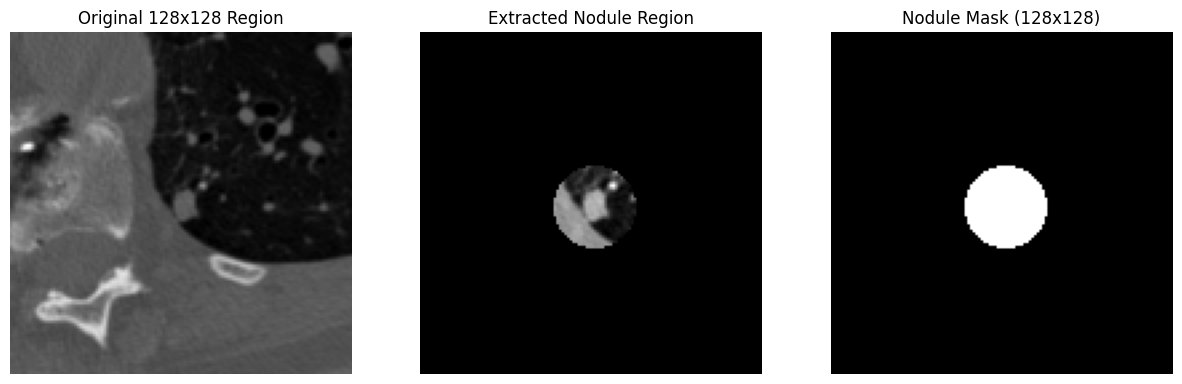

Visualizing mask 2_cmw_mask.npy from patient 2244 in class RealCancerous


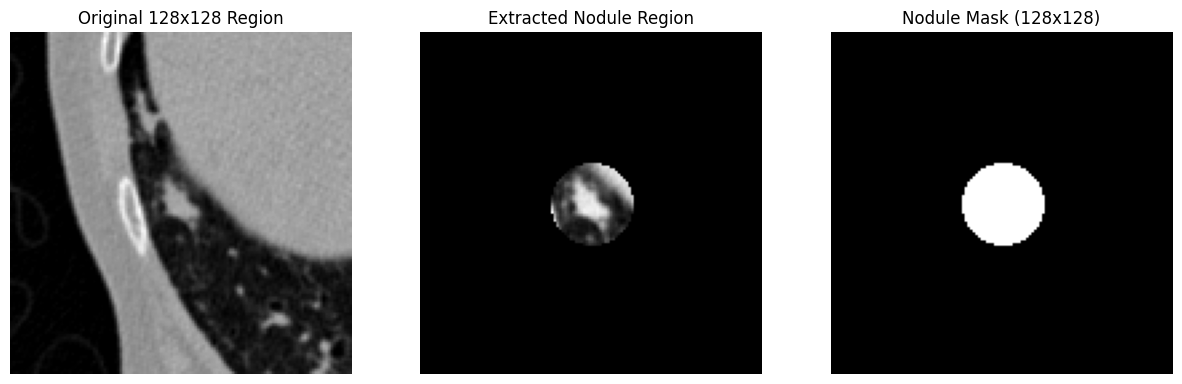

Visualizing mask 3_cmw_mask.npy from patient 2244 in class RealCancerous


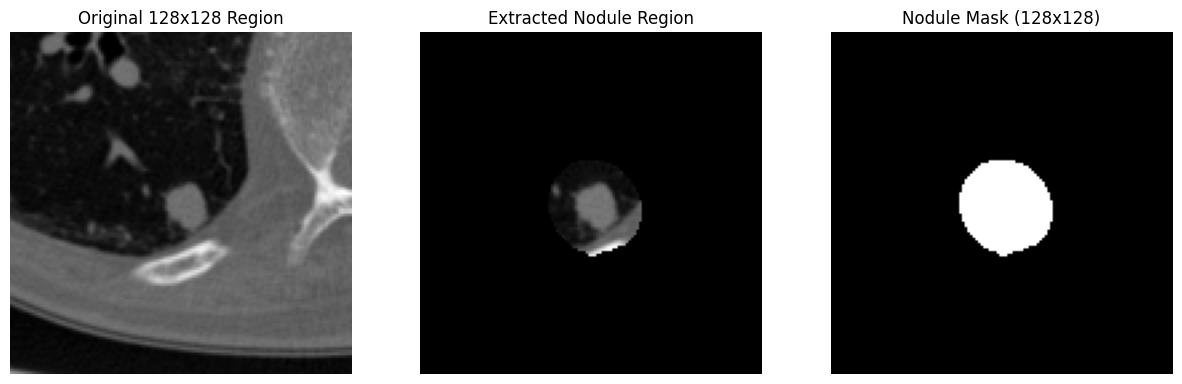

Visualizing mask 4_cmw_mask.npy from patient 2244 in class RealCancerous


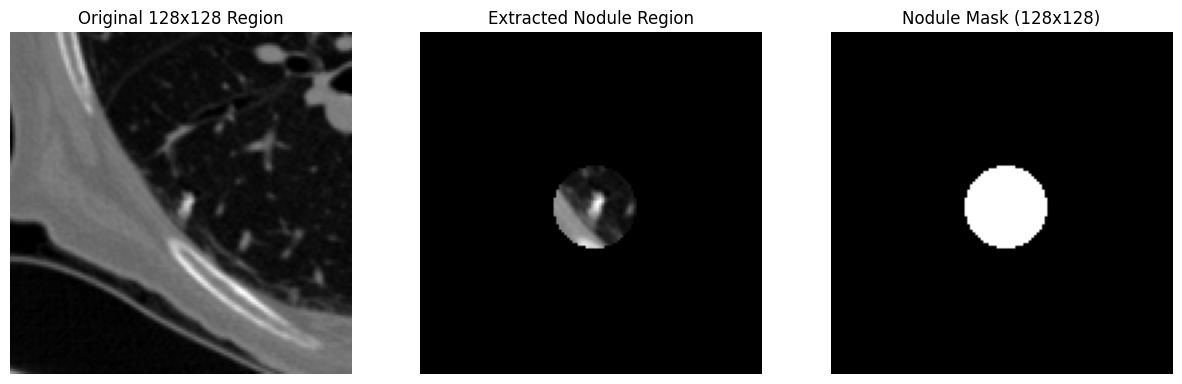

Visualizing mask 1_cmw_mask.npy from patient 2220 in class RealCancerous


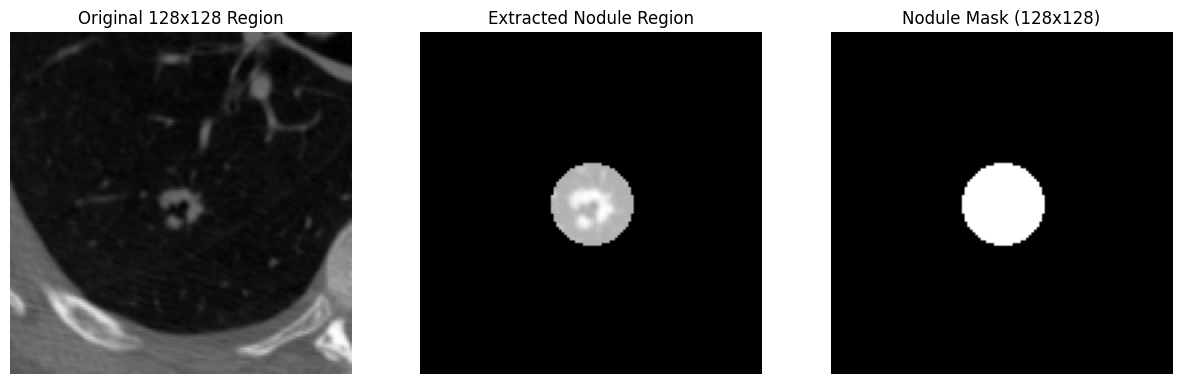

Finished visualizing 5 masks for class RealCancerous

Visualizing masks for class: FakeAddedCancer
Visualizing mask 1_cmw_mask.npy from patient 8971 in class FakeAddedCancer


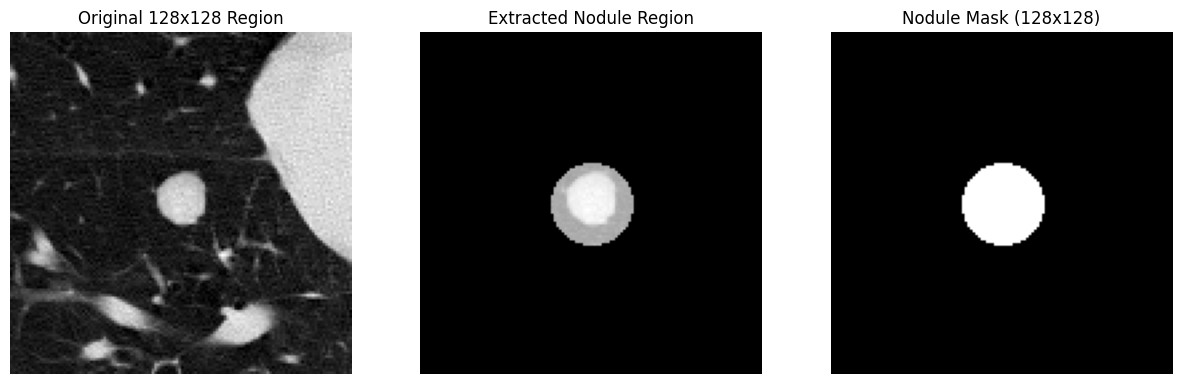

Visualizing mask 1_cmw_mask.npy from patient 1201 in class FakeAddedCancer


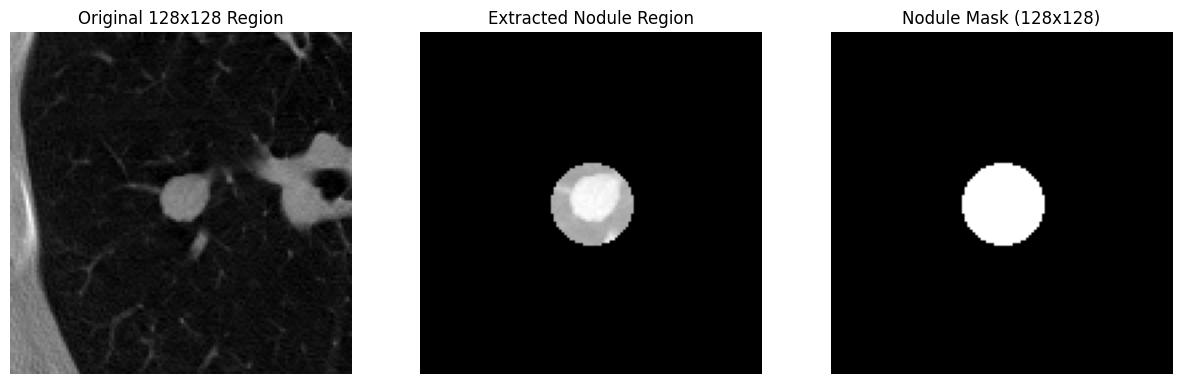

Visualizing mask 1_cmw_mask.npy from patient 2484 in class FakeAddedCancer


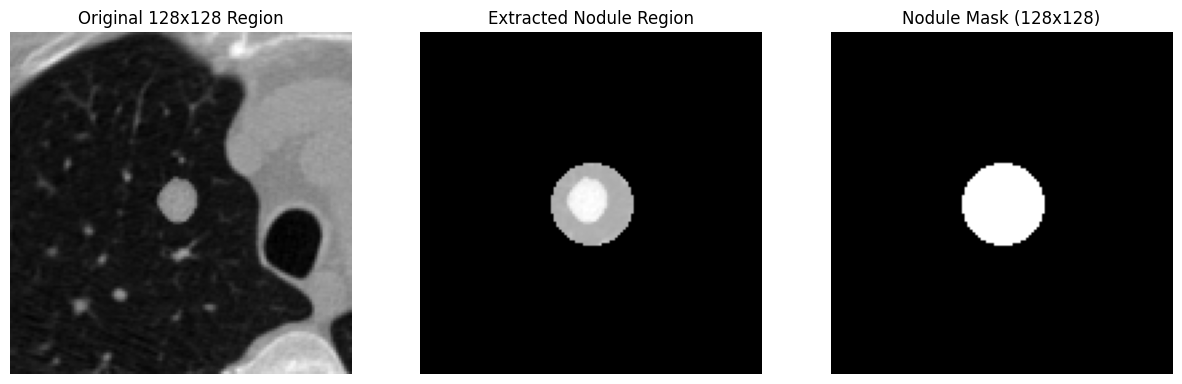

Visualizing mask 1_cmw_mask.npy from patient 1005 in class FakeAddedCancer


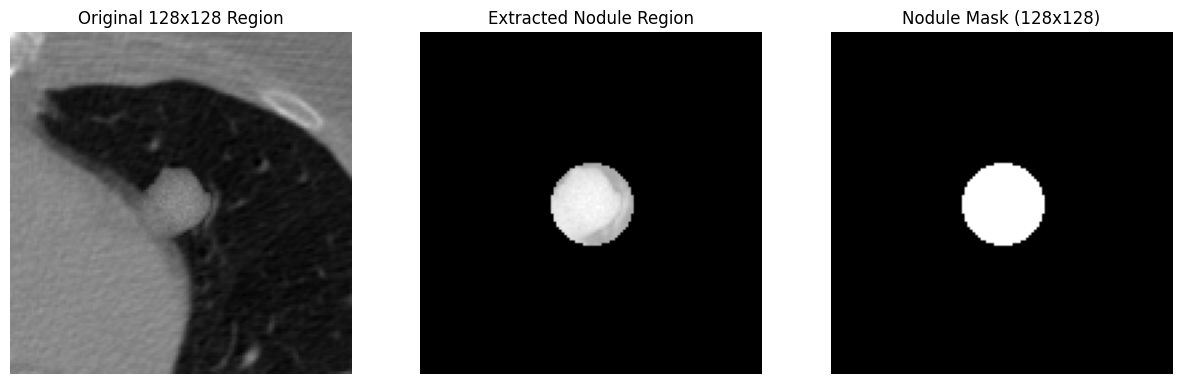

Visualizing mask 1_cmw_mask.npy from patient 2819 in class FakeAddedCancer


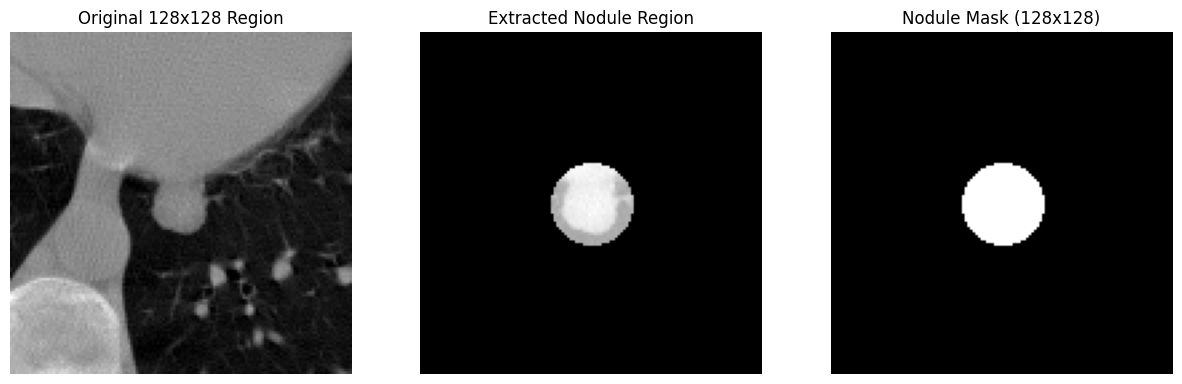

Finished visualizing 5 masks for class FakeAddedCancer


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

def find_nodule_center(mask_volume):
    """
    Finds the center of the masked nodule region in 3D.

    Parameters:
        mask_volume (np.array): 3D binary mask (same shape as CT scan).

    Returns:
        tuple: (z_center, y_center, x_center) coordinates of the nodule center.
    """
    coords = np.argwhere(mask_volume > 0)  # Find nonzero indices (z, y, x)
    
    if len(coords) == 0:
        raise ValueError("No nodule found in mask. Ensure the mask is correctly generated.")

    z_center, y_center, x_center = np.mean(coords, axis=0).astype(int)
    return z_center, y_center, x_center

def extract_128x128_region(ct_volume, mask_volume):
    """
    Extracts a 128x128 region centered around the nodule in the middle slice.

    Parameters:
        ct_volume (np.array): The full 3D CT scan.
        mask_volume (np.array): The 3D mask showing the nodule locations.

    Returns:
        tuple: Cropped (128x128) original CT scan, extracted nodule region, and corresponding mask.
    """
    # Find the nodule center
    z_center, y_center, x_center = find_nodule_center(mask_volume)

    # Define cropping bounds (ensure they remain within the image dimensions)
    half_size = 64  # 128x128 plane → half is 64 pixels
    y_min, y_max = max(0, y_center - half_size), min(ct_volume.shape[1], y_center + half_size)
    x_min, x_max = max(0, x_center - half_size), min(ct_volume.shape[2], x_center + half_size)

    # Crop the regions from the middle slice (z_center)
    cropped_original = ct_volume[z_center, y_min:y_max, x_min:x_max]
    # Use the mask to "extract" the nodule region; fill non-nodule areas with the minimum CT value
    cropped_extracted = np.where(mask_volume[z_center, y_min:y_max, x_min:x_max] > 0,
                                 ct_volume[z_center, y_min:y_max, x_min:x_max],
                                 np.min(ct_volume))
    cropped_mask = mask_volume[z_center, y_min:y_max, x_min:x_max]

    return cropped_original, cropped_extracted, cropped_mask

def display_128x128_region(original, extracted, mask):
    """
    Displays the 128x128 extracted region from the original scan, extracted nodule, and mask.

    Parameters:
        original (np.array): Cropped 128x128 region from the original CT scan.
        extracted (np.array): Cropped 128x128 extracted nodule region.
        mask (np.array): Cropped 128x128 mask.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original 128x128 Region")
    axes[0].axis("off")

    axes[1].imshow(extracted, cmap='gray')
    axes[1].set_title("Extracted Nodule Region")
    axes[1].axis("off")

    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title("Nodule Mask (128x128)")
    axes[2].axis("off")

    plt.show()

def main():
    # Base directory of processed data
    data_processed_root = "../data_processed"
    
    # Define the two classes
    classes = ["RealCancerous", "FakeAddedCancer"]
    
    # Number of visualizations to show per class
    num_visualizations = 5
    
    for cls in classes:
        print(f"\nVisualizing masks for class: {cls}")
        visualized = 0
        
        # Get the list of patient directories for this class
        class_dir = os.path.join(data_processed_root, cls)
        if not os.path.isdir(class_dir):
            print(f"Directory not found for class {cls}: {class_dir}")
            continue
        
        patient_dirs = [d for d in os.listdir(class_dir)
                        if os.path.isdir(os.path.join(class_dir, d))]
        
        # Iterate over patients until we have visualized the required number of masks
        for patient in patient_dirs:
            patient_dir = os.path.join(class_dir, patient)
            # CT scan file is named as "[patient]_full_volume.npy"
            ct_scan_file = os.path.join(patient_dir, f"{patient}_full_volume.npy")
            if not os.path.isfile(ct_scan_file):
                print(f"CT scan file not found for patient {patient}: {ct_scan_file}")
                continue
            
            ct_volume = np.load(ct_scan_file)
            # Find mask files in the patient directory that end with "_cmw_mask.npy"
            mask_files = [f for f in os.listdir(patient_dir)
                          if f.endswith("_cmw_mask.npy")]
            
            for mask_file in mask_files:
                mask_path = os.path.join(patient_dir, mask_file)
                try:
                    mask_volume = np.load(mask_path)
                    cropped_original, cropped_extracted, cropped_mask = extract_128x128_region(ct_volume, mask_volume)
                    print(f"Visualizing mask {mask_file} from patient {patient} in class {cls}")
                    display_128x128_region(cropped_original, cropped_extracted, cropped_mask)
                    visualized += 1
                    if visualized >= num_visualizations:
                        break
                except Exception as e:
                    print(f"Error processing mask {mask_file} from patient {patient}: {e}")
            if visualized >= num_visualizations:
                break
        
        print(f"Finished visualizing {visualized} masks for class {cls}")

if __name__ == "__main__":
    main()


# Perform Automated Seeded Growing to get Isolated Nodule Masks


Processing ASRG for class: RealCancerous
  Processing patient: 2244
Saved ASRG mask: ../data_processed/RealCancerous/2244/1_asrg_mask.npy
Saved ASRG mask: ../data_processed/RealCancerous/2244/2_asrg_mask.npy
Saved ASRG mask: ../data_processed/RealCancerous/2244/3_asrg_mask.npy
Saved ASRG mask: ../data_processed/RealCancerous/2244/4_asrg_mask.npy
  Processing patient: 2220
Saved ASRG mask: ../data_processed/RealCancerous/2220/1_asrg_mask.npy
Saved ASRG mask: ../data_processed/RealCancerous/2220/2_asrg_mask.npy
  Processing patient: 1546
Saved ASRG mask: ../data_processed/RealCancerous/1546/1_asrg_mask.npy
  Processing patient: 3025
Saved ASRG mask: ../data_processed/RealCancerous/3025/1_asrg_mask.npy
  Processing patient: 2575
Saved ASRG mask: ../data_processed/RealCancerous/2575/1_asrg_mask.npy
Saved ASRG mask: ../data_processed/RealCancerous/2575/2_asrg_mask.npy
  Processing patient: 3099
Saved ASRG mask: ../data_processed/RealCancerous/3099/1_asrg_mask.npy
  Processing patient: 6031

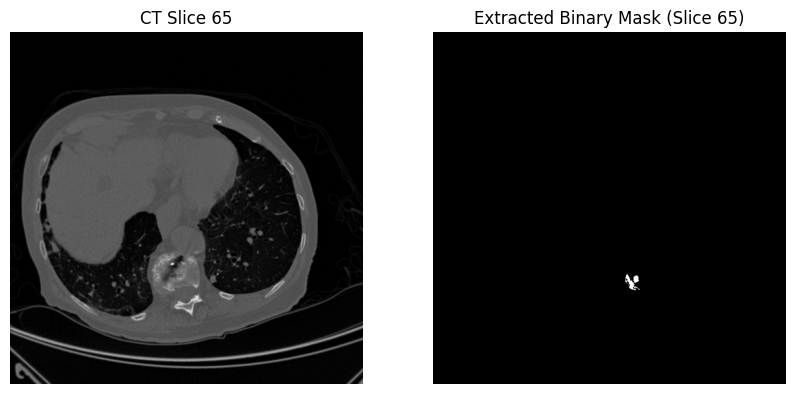

Visualizing ASRG mask from patient 2244, file: 2_asrg_mask.npy


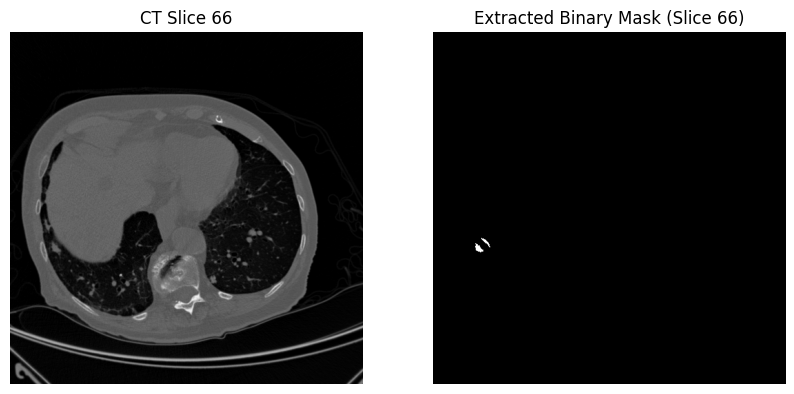

Visualizing ASRG mask from patient 2244, file: 3_asrg_mask.npy


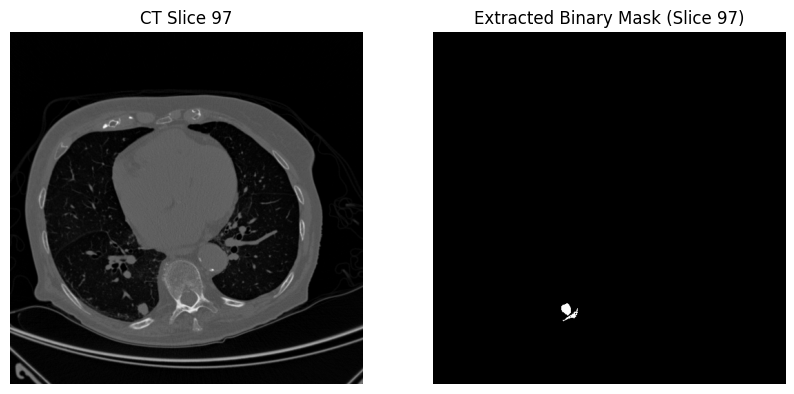

Visualizing ASRG mask from patient 2244, file: 4_asrg_mask.npy


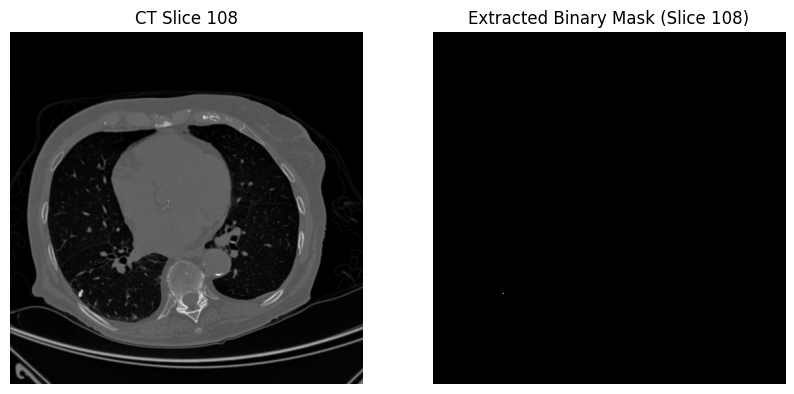

Visualizing ASRG mask from patient 2220, file: 1_asrg_mask.npy


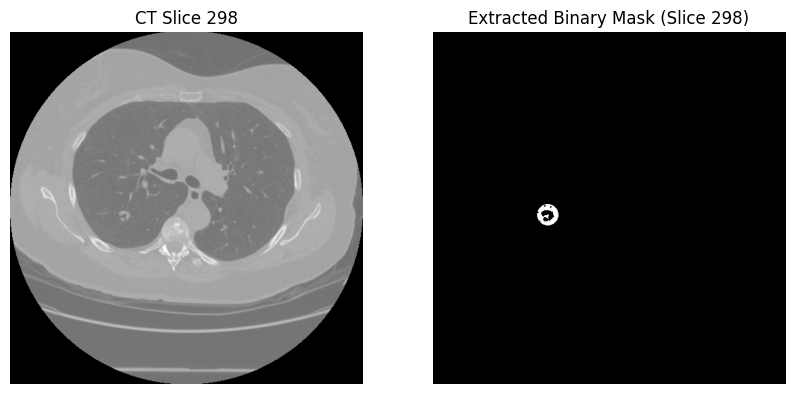

Displayed 5 ASRG cases for class RealCancerous.

Visualizing 5 ASRG cases for class: FakeAddedCancer
Visualizing ASRG mask from patient 8971, file: 1_asrg_mask.npy


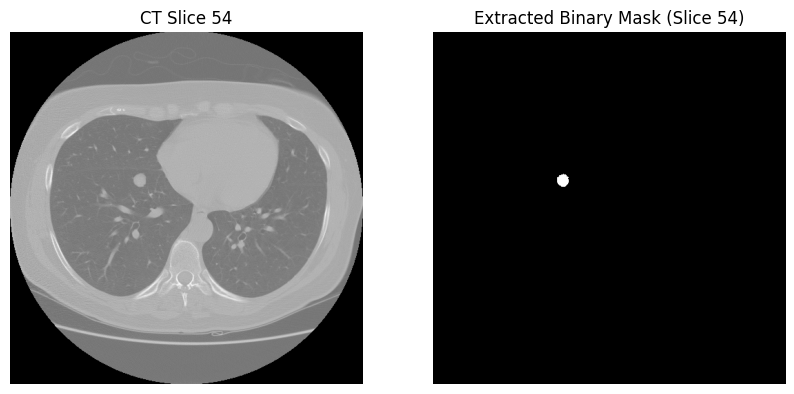

Visualizing ASRG mask from patient 1201, file: 1_asrg_mask.npy


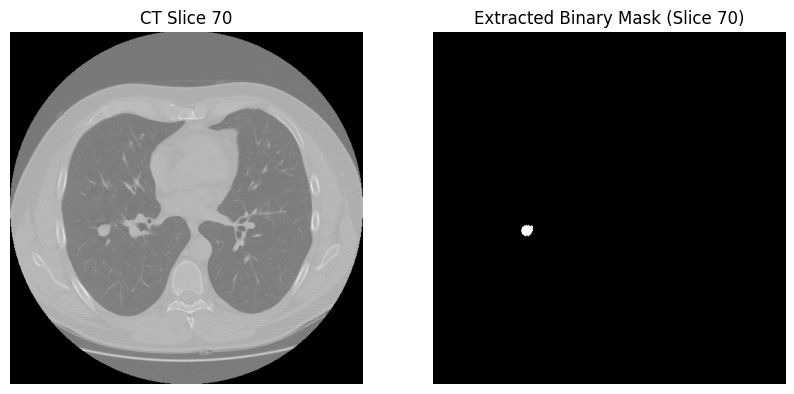

Visualizing ASRG mask from patient 2484, file: 1_asrg_mask.npy


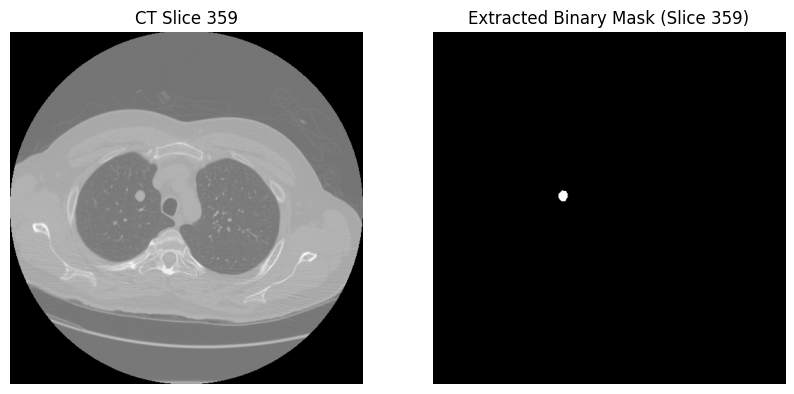

Visualizing ASRG mask from patient 1005, file: 1_asrg_mask.npy


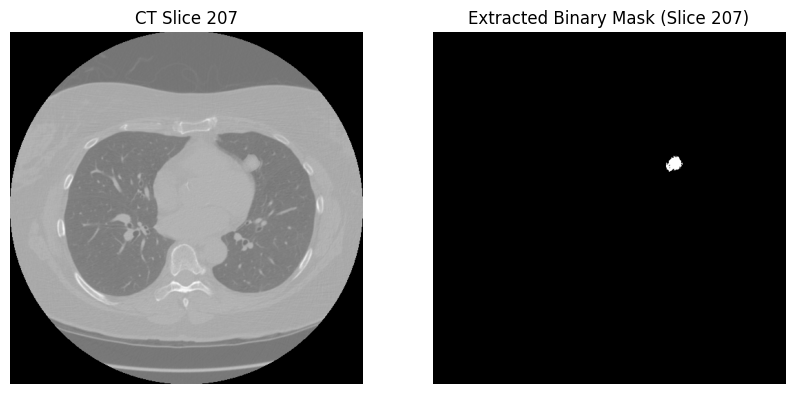

Visualizing ASRG mask from patient 2819, file: 1_asrg_mask.npy


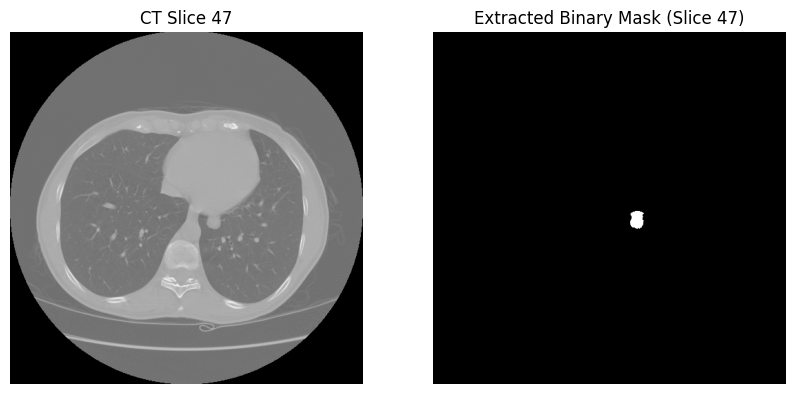

Displayed 5 ASRG cases for class FakeAddedCancer.


In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def load_data(ct_scan_path, mask_path):
    """
    Load the CT scan (HU) and ROI mask from .npy files.
    """
    ct_volume = np.load(ct_scan_path)
    roi_mask = np.load(mask_path)
    return ct_volume, roi_mask

def get_seed_point(roi_mask):
    """
    Automatically determine a seed point from the ROI mask.
    Computes the centroid of all nonzero voxels.
    
    Returns:
        seed (tuple): (z, y, x) coordinates of the seed.
    """
    coords = np.argwhere(roi_mask > 0)
    if coords.size == 0:
        raise ValueError("ROI mask is empty. Cannot determine seed point.")
    centroid = np.mean(coords, axis=0)
    seed = tuple(np.round(centroid).astype(int))
    return seed

def region_growing(ct_volume, roi_mask, seed, threshold=50):
    """
    Perform region growing within the ROI defined by roi_mask on the CT volume.
    
    Voxels are added if:
      - They are within the ROI mask.
      - Their intensity difference from the seed intensity is <= threshold.
    
    Parameters:
        ct_volume (np.array): 3D CT scan (HU).
        roi_mask (np.array): Binary ROI mask (nonzero indicates region of interest).
        seed (tuple): (z, y, x) seed point for region growing.
        threshold (float): Intensity threshold (HU difference).
    
    Returns:
        region_mask (np.array): Binary mask (same shape as ct_volume) of the grown region.
    """
    shape = ct_volume.shape
    visited = np.zeros(shape, dtype=bool)
    region_mask = np.zeros(shape, dtype=np.uint8)
    
    seed_intensity = ct_volume[seed]
    neighbor_offsets = [(1, 0, 0), (-1, 0, 0),
                        (0, 1, 0), (0, -1, 0),
                        (0, 0, 1), (0, 0, -1)]
    
    queue = deque()
    queue.append(seed)
    visited[seed] = True
    
    while queue:
        current = queue.popleft()
        region_mask[current] = 1
        for offset in neighbor_offsets:
            nz = current[0] + offset[0]
            ny = current[1] + offset[1]
            nx = current[2] + offset[2]
            if nz < 0 or nz >= shape[0] or ny < 0 or ny >= shape[1] or nx < 0 or nx >= shape[2]:
                continue
            if visited[nz, ny, nx]:
                continue
            # Only consider voxels within the ROI mask
            if roi_mask[nz, ny, nx] == 0:
                continue
            # Check if intensity difference is within threshold
            if abs(int(ct_volume[nz, ny, nx]) - int(seed_intensity)) <= threshold:
                queue.append((nz, ny, nx))
                visited[nz, ny, nx] = True
                
    return region_mask

def display_extracted_region(ct_volume, region_mask, slice_index):
    """
    Display the CT slice and the extracted binary region mask at a specified slice.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_volume[slice_index], cmap='gray')
    plt.title(f"CT Slice {slice_index}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(region_mask[slice_index], cmap='gray')
    plt.title(f"Extracted Binary Mask (Slice {slice_index})")
    plt.axis('off')
    plt.show()

def process_asrg_for_patient(patient_dir, threshold=200):
    """
    For a given patient directory, load the full CT scan and process each CMW mask file.
    For each CMW mask ([nodule_number]_cmw_mask.npy), perform ASRG on its ROI and save the result
    as [nodule_number]_asrg_mask.npy.
    
    Returns a list of tuples: (patient_dir, output_mask_path, seed) for visualization.
    """
    patient_id = os.path.basename(patient_dir)
    ct_scan_path = os.path.join(patient_dir, f"{patient_id}_full_volume.npy")
    if not os.path.isfile(ct_scan_path):
        print(f"CT volume file not found for patient {patient_id}: {ct_scan_path}")
        return []
    ct_volume = np.load(ct_scan_path)
    
    asrg_outputs = []
    # Process all CMW mask files
    cmw_files = [f for f in os.listdir(patient_dir) if f.endswith("_cmw_mask.npy")]
    for cmw_file in cmw_files:
        cmw_path = os.path.join(patient_dir, cmw_file)
        try:
            roi_mask = np.load(cmw_path)
            seed = get_seed_point(roi_mask)
            region_mask = region_growing(ct_volume, roi_mask, seed, threshold=threshold)
            binary_region_mask = (region_mask > 0).astype(np.uint8)
            asrg_file = cmw_file.replace("cmw", "asrg")
            output_path = os.path.join(patient_dir, asrg_file)
            np.save(output_path, binary_region_mask)
            print(f"Saved ASRG mask: {output_path}")
            asrg_outputs.append((patient_dir, output_path, seed))
        except Exception as e:
            print(f"Error processing {cmw_file} in patient {patient_id}: {e}")
    return asrg_outputs

def main():
    # Base processed data directory
    data_processed_root = "../data_processed"
    classes = ["RealCancerous", "FakeAddedCancer"]
    threshold = 200  # ASRG intensity threshold
    # Dictionary to store ASRG outputs for visualization per class
    asrg_display_results = {cls: [] for cls in classes}
    
    # Process entire dataset
    for cls in classes:
        print(f"\nProcessing ASRG for class: {cls}")
        class_dir = os.path.join(data_processed_root, cls)
        if not os.path.isdir(class_dir):
            print(f"Directory not found for class {cls}: {class_dir}")
            continue
        patient_dirs = [os.path.join(class_dir, d) for d in os.listdir(class_dir)
                        if os.path.isdir(os.path.join(class_dir, d))]
        for patient_dir in patient_dirs:
            patient_id = os.path.basename(patient_dir)
            print(f"  Processing patient: {patient_id}")
            asrg_results = process_asrg_for_patient(patient_dir, threshold=threshold)
            asrg_display_results[cls].extend(asrg_results)
    
    # After processing, display 5 cases per class
    num_visualizations = 5
    for cls in classes:
        print(f"\nVisualizing {num_visualizations} ASRG cases for class: {cls}")
        count = 0
        for (patient_dir, output_path, seed) in asrg_display_results[cls]:
            if count >= num_visualizations:
                break
            patient_id = os.path.basename(patient_dir)
            ct_scan_path = os.path.join(patient_dir, f"{patient_id}_full_volume.npy")
            if not os.path.isfile(ct_scan_path):
                continue
            ct_volume = np.load(ct_scan_path)
            asrg_mask = np.load(output_path)
            slice_to_display = seed[0]  # Use seed's z-coordinate for display
            print(f"Visualizing ASRG mask from patient {patient_id}, file: {os.path.basename(output_path)}")
            display_extracted_region(ct_volume, asrg_mask, slice_to_display)
            count += 1
        print(f"Displayed {count} ASRG cases for class {cls}.")

if __name__ == "__main__":
    main()
